## Super resolution

In [1]:
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

Untar the data at `URLs.PETS` and save the pth to `path`. Set `path/'images'` to `path_hr`, `path/'small-96'` to `path_lr`, and `path/'small-256'` to path_mr.

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

Create an image list from the images at `path_hr`.

In [4]:
il = ImageList.from_folder(path_hr)

Define a funtion `resize_one` that does the following:
- takes args fn, i, path, size
- gets the path `path/fn.relative_to(path_r)` and saves it to dest. what does this do?
- makes the path directory if it doesn't already exist (see path.parent.mkdir for a hint)
- Opens fn with PIL
- targ_sz = resize_to(img, size, use_min=True) -- can you explain what this does?
- create a new image `img` that resizes `img` to `targ_sz` with PIL.IMage.BILINEAR resampling, and convert it to RGB
- save the image to dest

In [5]:
def resize_one(fn, i, path, size, show=False):
    dest = path/fn.relative_to(path_hr)
    path.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    # it gets the new (w,h) tuple to resize the img by maintaining the aspect ratio
    # of the image and setting the minimum-length side
    # of the image to the specified size; does not actually perform the resizing
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60) 
    return img

In [6]:
doc(resize_to)

In [7]:
im = resize_one(il.items[0], 1, path, 100, True)

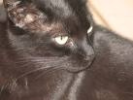

In [8]:
im

Create a list of 2-tuples each with two elements: a path and a size. The list will containe two tuples: 
- (path_lr, 96)
- (path_mr, 256)

Iterating over them, if the path doesn't exist, call `partial(resize_one, path=p, size=size)` over `il.items` in parallel. 

In [9]:
for path, size in [(path_lr, 96), (path_mr, 256)]:
    if not path.exists():
        parallel(partial(resize_one, path=path, size=size))

Set bs to 32 and size to 128. Set rch to models.resnet34. Create an ImageItemList from the folder `path_lr` split by a random 10% with a random seed of 42.

In [10]:
bs=32; size=128

Write a function `get_data` that takes a `bs` and a `size` and outputs a databunch. Hints:
- Label with a function that points to the file's counterpart in `path_hr`
- transform the data using `get_transforms`, only overriding `max_zoom=2.`, size=size, tfm_y=True
- normalize the `y`'s as well
- Set `data.c` to 3

In [11]:
def get_data(bs, size):
    src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
    tfms = get_transforms(max_zoom=2.)
    data = (src
            .label_from_func(lambda x: path_hr/x.name)
            .transform(tfms, size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

Call `get_data` and assign to `data`

In [23]:
data = get_data(bs, size)

Show a batch of data from the validation set over 2 rows with figsize (9,9).

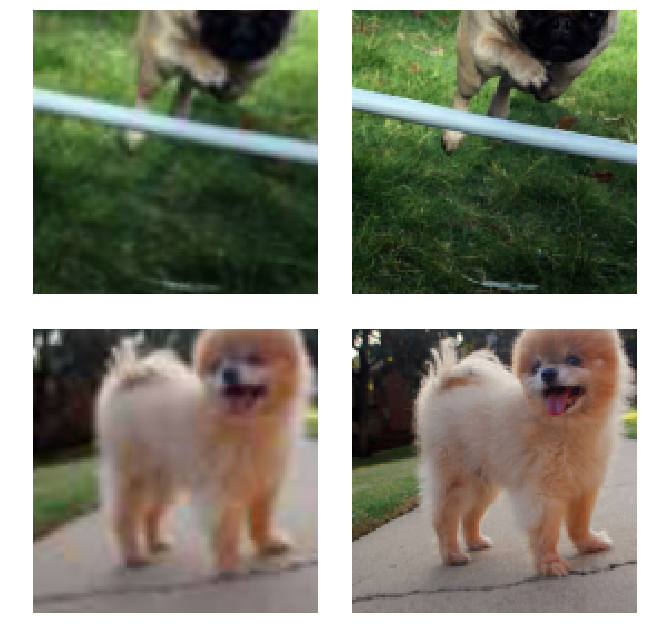

In [24]:
data.show_batch(rows=2, figsize=(9,9))

## Feature loss

Get the `data` of the label value of the first item in the validation set, and assign it to `t`. Then `torch.stack` it with itself. What does this do?

In [26]:
t = data.valid_ds[0][1].data

In [27]:
t

tensor([[[0.2167, 0.3392, 0.3157,  ..., 0.7873, 0.7647, 0.7209],
         [0.2230, 0.2502, 0.3312,  ..., 0.8085, 0.8399, 0.7352],
         [0.3101, 0.2774, 0.3330,  ..., 0.8474, 0.8300, 0.7409],
         ...,
         [0.4307, 0.3864, 0.4554,  ..., 0.4123, 0.3308, 0.4666],
         [0.3572, 0.4054, 0.4617,  ..., 0.4430, 0.4311, 0.5043],
         [0.3088, 0.3549, 0.4333,  ..., 0.4088, 0.3686, 0.4810]],

        [[0.3441, 0.4461, 0.3765,  ..., 0.7294, 0.7186, 0.6444],
         [0.3138, 0.3356, 0.4051,  ..., 0.7460, 0.8011, 0.6799],
         [0.4282, 0.3317, 0.4095,  ..., 0.8044, 0.7921, 0.6918],
         ...,
         [0.6850, 0.6219, 0.6711,  ..., 0.6694, 0.5386, 0.6903],
         [0.5978, 0.6511, 0.7009,  ..., 0.7078, 0.6475, 0.7335],
         [0.5500, 0.6127, 0.6784,  ..., 0.6539, 0.5833, 0.7046]],

        [[0.2382, 0.3892, 0.3608,  ..., 0.7029, 0.6892, 0.6000],
         [0.2492, 0.2925, 0.4070,  ..., 0.6943, 0.7388, 0.6100],
         [0.3988, 0.2957, 0.4080,  ..., 0.7465, 0.6948, 0.

In [28]:
t.shape

torch.Size([3, 128, 128])

In [29]:
t = torch.stack([t, t])

In [30]:
t.shape

torch.Size([2, 3, 128, 128])

write a function `gram_matrix` that:
- reads `x.size()` into `n,c,h,w`. What do each of these represent?
- sets `x` to `x.view(n, c, -1)`. What does this do?
- returns x times its own transpose divided by the scalar c * h * w, which is the total number of elements in each example

Show the gram matrix of `t`.

Set base_loss to `F.l1_loss`.

Set `vgg_m` to `vgg16_bn(True).features.cuda().eval().` What does all this do? Call `requires_grad(vgg_m, False)`. What is this about?

Write a function that gets a list of the indices before every `nn.MaxPool2d` layer. Print the list of indices and the layers themselves (Hint: for the latter, you may want to use a list comprehension).

Now we're going to create our own `FeatureLoss` architecture in pytorch! First, create the scaffolding for a class `FeatureLoss` that inherits from `nn.Module`. The `__init__` method is going to take `m_feat`, `layer_ids`, and `layer_wgts`. `m_feat` is a collection of layers, like `vgg_m`. `layer_ids` is a list of ids that we'll use to index into `vgg_m`. In `__init__`, we'll want to save all of the layers from `m_feat` with indices in `layer_ids` to `self.loss_features`. Call `hook_outputs` on `self.loss_features` with `detach=False`. What does this do? Set `self.wgts` to `layer_wgts`. Set `self.metric_names` to `['pixel',]` + a list with each element being `'feat_{i}'` for each of the layer ids, and the same for `'gram_{i}'` which will represent the gram matrix metrics for each of the layer ids (more on this in a bit).

Write a method `make_features` that takes `x` and `clone=False`. It will call `self.m_feat` on `x`, which will update all the hooks in place automatically. If clone, make a clone of each of the output activations in the hooks, otherwise return the actual output activations. 

Finally, we'll write `forward`, the main method for defining a custom network in a `nn.Module`. This will take `input` and `output`. Set `out_feat` with the result of `self.make_features(target)`. Set `in_feat` to `self.make_features(input)`. Set `feat_losses` to a single-element list containing `base_loss` computed on `input` and `output`. Add to that an array containing the `base_loss` called on `f_in` and `f_out`, times the weight, for each `f_in`, `f_out`, and `weight` in `in_feat`, `out_feat`, and `weights` zipped together. Next, do the same, but the array will be `base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2*5e-3` for the `f_in`, `f_out` and `self.wgts` zipped together. Finally, we'll set `self.metrics` to a dict of `self.metric_names` zipped to `self.feat_losses`, and then return the sum of the feature losses.

Next we define `__del__`, which removes the hooks from the output activations. 

Now we instantiate a `FeatureLoss` with `vgg_m`, `blocks[2:5]`, and `[5,15,2]`. Can you explain what these args are referring to?

## Train

Set `wd=1e-3`. Create a `unet_learner` with `data`, `arch`, `wd`, `feat_loss` as our loss function, `LossMetrics` as our loss function, with `blur` set, and norm_type set to `NormType.Weight`. Can you explain what the last two do? Call `gc.collect`.

Next we run an `lr_find` and plot the results.

The lr should be somewhere around 1e-3. Set it accordingly.

Write a function `do_fit` that takes a `save_name`, a set of `lrs` that defaults to `slice(lr)`, and a `pct_start` that defaults to 0.9. It should:
- Fit a 10-epoch cycle with `lrs` and `pct_start`
- Save the results to `save_name`
- Show the results in one row with an img size of 5

Call `do_fit` with name `1a` and `slice(lr*10)`.

Unfreeze `learn`.

Call `do_fit` again with `1b` and `slice(1e-5)`.

Call `get_data` with `12` and `size*2` and set it to `data`.

Set `learn.data` to `data`, freeze it again, and `gc.collect` again.

Load `1b`.

`do_fit` on `'2a'`.

Unfreeze `learn`.

do_fit on `2b`, with `slice(1e-6, 1e-4)`, `pct_start=0.3`.

## Test

Set `learn` to `None`.

Assign `free` to the result of `gpu_mem_get_free_no_cache()`. If free > 8000, set `size` to `(1280, 1600)`, else `(820, 1024)`. Print how much you're using and how much free RAM you have. 

Create a `unet_learner` called `learn` with `data`, `arch`, `F.l1_loss`, blur, and `norm_type=NormType.Weight`.

Create `data_mr` using the datablock API. Some details:
- You'll want to create an ImageImageList from a folder, split by a random 10% with seed 42
- You'll want to label from a function that returns the image's name in `path_hr`
- You'll want to transform it with `get_transforms` and `size=size` and transform `y` as well.
- Create a databunch with a bs of 1 and normalize with imagenet_stats, and do_y as well
- Set the number of categories to 3.

Load `2b` with `learn`.

Set the data to data_mr.

Get `fn` (for filename) from the first item in the `x` part of the validation dataset.

Get `img` by opening `fn`. Print its shape.

Unpack `learn.predict(img)` into `p, img_hr, b`. What do these represent?

Show `img` with a figsize of (18, 15) and an interpolation of `nearest`.